In [21]:
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import kagglehub
from tqdm import tqdm
import numpy as np
import requests
from IPython.display import clear_output
import torch.nn as nn
import time
import matplotlib.pyplot as plt
from source.utils import obtain_data
from torch.quantization import quantize_dynamic
from transformers import GPT2Tokenizer, GPT2Config, GPT2LMHeadModel, AdamW, get_linear_schedule_with_warmup
import json
import string
#from datasets import load_dataset
from wordcloud import WordCloud
import re
import collections
import string
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
import pkg_resources
version = pkg_resources.get_distribution("datasets").version
version

'3.4.1'

In [3]:
# PARAMS
MAX_LENGTH = 400
BATCH_SIZE = 2
EPOCHS = 10
LEARNING_RATE = 2e-5
WARMUP_STEPS = 0.1

# Load data

### Baudelaire

In [4]:
path = "https://raw.githubusercontent.com/AmelNozieres/NLP_Generate_poems/master/Les_fleurs_du_mal_Baudelaire"
response = requests.get(path)
poems = response.text
corpus = poems.lower().split("\n")
corpus = [text.translate(str.maketrans('', '', string.punctuation)) for text in corpus]
vocab = poems.split(' ')
vocab = [element.strip() for element in vocab]
chars = sorted(list(set(vocab)))
chars = [element.replace('\n', '') for element in chars]

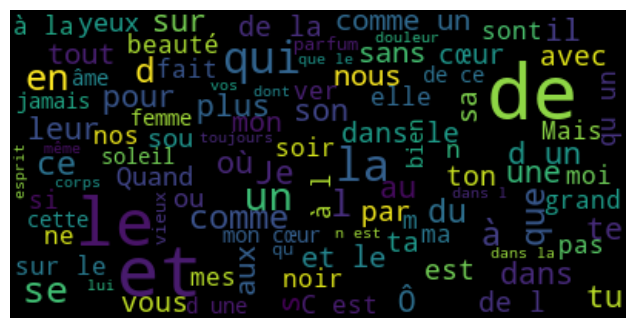

In [5]:
wordcloud = WordCloud(max_font_size=50,
                      max_words=100,
                      background_color="black").generate(poems)

# Plotting the WordCloud
plt.figure(figsize=(8, 4))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig("WordCloud.png")
plt.show()

### Kaggle dataset

In [11]:
rootdir = '/Users/augustincablant/Documents/GitHub/NLP-Class/Project/data'
poems_data, poems_dataset = obtain_data(rootdir)

Loaded 20625 poems:
- Forms: 6306
- Topics: 14319


# Exploratory Data Analysis

### Baudelaire

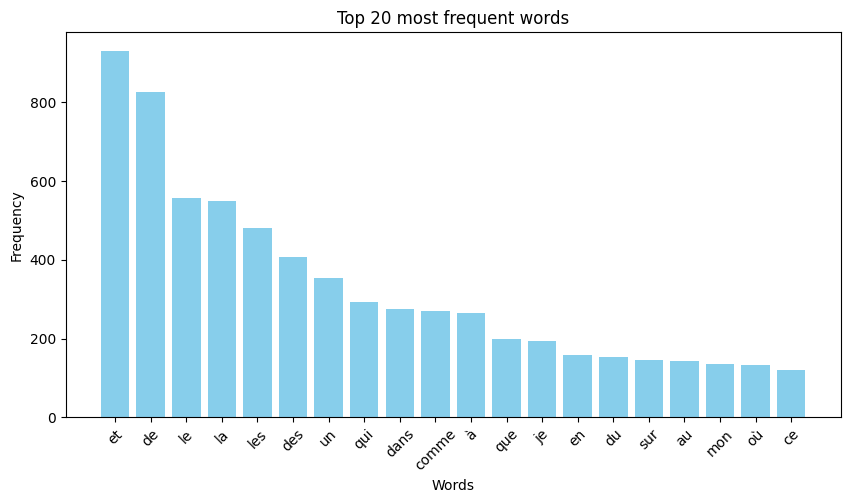

In [7]:
def preprocess(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    return text.split()

word_counts = collections.Counter()
for sentence in corpus:
    word_counts.update(preprocess(sentence))

most_common_words = word_counts.most_common(20)
words, counts = zip(*most_common_words)

# plot
plt.figure(figsize=(10, 5))
plt.bar(words, counts, color='skyblue')
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.title("Top 20 most frequent words")
plt.xticks(rotation=45)
plt.show()

### Kaggle dataset

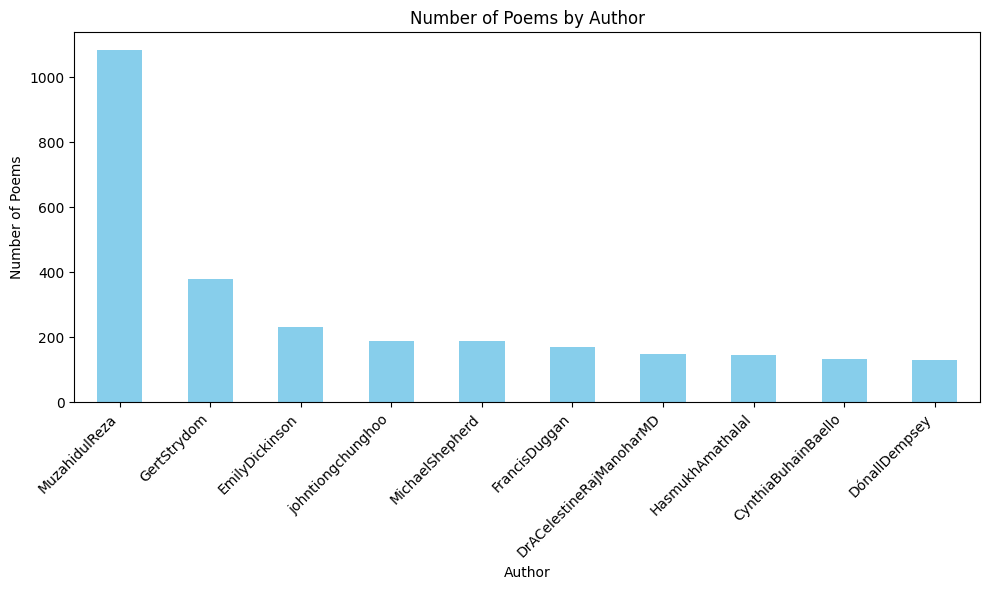

In [8]:
author_counts = poems_dataset['author'].value_counts()[:10]
plt.figure(figsize=(10, 6))
author_counts.plot(kind='bar', color='skyblue')
plt.title('Number of Poems by Author')
plt.xlabel('Author')
plt.ylabel('Number of Poems')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Create the dataset and the model

In [14]:
MAX_LENGTH = 400
BATCH_SIZE = 2
EPOCHS = 10
LEARNING_RATE = 2e-5
WARMUP_STEPS = 0.1

class PoetryDataset(Dataset):
    def __init__(self, poems_data, tokenizer, max_length, device):
        self.input_ids = []
        self.attn_masks = []
        self.categories = []
        
        for poem in tqdm(poems_data):
            # Format text with hierarchical categories
            full_text = f"Author: {poem['author']}\n" \
                       f"Category: {poem['main_category']}/{poem['sub_category']}\n\n{poem['text']}"
            
            encodings = tokenizer(
                full_text,
                truncation=True,
                max_length=max_length,
                padding='max_length',
                return_tensors='pt'
            )
            
            self.input_ids.append(encodings['input_ids'][0].to(device))
            self.attn_masks.append(encodings['attention_mask'][0].to(device))
            self.categories.append(f"{poem['main_category']}/{poem['sub_category']}")
    
    def __len__(self):
        return len(self.input_ids)
    
    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attn_masks[idx],
            'category': self.categories[idx]
        }

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Initialize tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token

# Model configuration
config = GPT2Config(
    n_positions=MAX_LENGTH,
    n_ctx=MAX_LENGTH,
    n_embd=384,
    n_layer=6,
    n_head=6,
    vocab_size=50257,
    bos_token_id=50256,
    eos_token_id=50256,
)

# Initialize model
model = GPT2LMHeadModel(config).to(device)

Using device: cpu


In [15]:
dataset = PoetryDataset(poems_data, tokenizer, MAX_LENGTH, device)
train_dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(WARMUP_STEPS * len(train_dataloader) * EPOCHS),
    num_training_steps=len(train_dataloader) * EPOCHS
)
scaler = torch.cuda.amp.GradScaler()

100%|██████████| 20625/20625 [00:12<00:00, 1665.61it/s]
/opt/anaconda3/lib/python3.12/site-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/var/folders/t6/khg6jj9s4_b0lqrt24p4bvs00000gn/T/ipykernel_78767/2965615843.py:10: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
/opt/anaconda3/lib/python3.12/site-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 10/10 | Batch 10310/10313 | Loss: 2.2752 | Time: 3812.41s


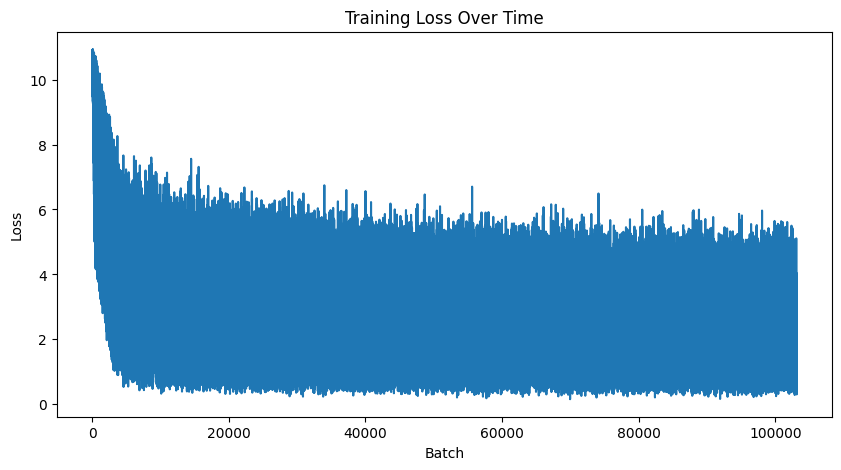

100%|██████████| 10/10 [12:14:50<00:00, 4409.04s/it] 


In [16]:
model.train()
total_start_time = time.time()
losses = []

for epoch in tqdm(range(EPOCHS)):
    epoch_start_time = time.time()
    total_loss = 0
    batch_times = []
    
    for batch_num, batch in enumerate(train_dataloader, 1):
        batch_start_time = time.time()
        
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        
        with torch.cuda.amp.autocast():
            outputs = model(
                input_ids,
                attention_mask=attention_mask,
                labels=input_ids
            )
            loss = outputs.loss
        
        total_loss += loss.item()
        losses.append(loss.item())
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()
        optimizer.zero_grad()
        
        # Display progress
        if batch_num % 5 == 0:
            clear_output(wait=True)
            elapsed_time = time.time() - epoch_start_time
            avg_loss = total_loss / batch_num
            print(f'Epoch {epoch+1}/{EPOCHS} | Batch {batch_num}/{len(train_dataloader)} | '
                  f'Loss: {avg_loss:.4f} | Time: {elapsed_time:.2f}s')
            
            # Plot loss curve
            plt.figure(figsize=(10, 5))
            plt.plot(losses)
            plt.title('Training Loss Over Time')
            plt.xlabel('Batch')
            plt.ylabel('Loss')
            plt.show()

In [17]:
torch.save(model.state_dict(), "trained_model.pth")

In [ ]:
model.load_state_dict(torch.load("trained_model.pth"))

# Generation

In [22]:
def save_quantized_model(model, tokenizer, max_length, save_path):
    model = model.cpu()
    quantized_model = quantize_dynamic(
        model,
        {torch.nn.Linear},  # Specify the layers to quantize
        dtype=torch.qint8
    )
    torch.save(quantized_model.state_dict(), f"{save_path}/poeticagpt-quantized-new.pth")
    tokenizer.save_pretrained(save_path)
    example_input = torch.zeros((1, max_length), dtype=torch.long)
    try:
        traced_model = torch.jit.trace(quantized_model, example_input)
        torch.jit.save(traced_model, f"{save_path}/poeticagpt-quantized-traced.pt")
        test_input = torch.zeros((1, max_length), dtype=torch.long)
        traced_output = traced_model(test_input)
        print("Model tracing successful!")
        
    except Exception as e:
        print(f"Error during model tracing: {str(e)}")
        print("Saving only the quantized state dict instead.")
    return quantized_model

In [28]:
torch.backends.quantized.engine = "qnnpack"
save_path = "/Users/augustincablant/Documents/GitHub/NLP-Class/Project"

quantized_model = save_quantized_model(
    model=model,
    tokenizer=tokenizer,
    max_length=MAX_LENGTH,
    save_path=save_path
)

/opt/anaconda3/lib/python3.12/site-packages/transformers/modeling_utils.py:4481: FutureWarning: `_is_quantized_training_enabled` is going to be deprecated in transformers 4.39.0. Please use `model.hf_quantizer.is_trainable` instead
  warnings.warn(
[W324 22:30:03.091895000 qlinear_dynamic.cpp:250] Warning: Currently, qnnpack incorrectly ignores reduce_range when it is set to true; this may change in a future release. (function operator())


Error during model tracing: Tracer cannot infer type of CausalLMOutputWithCrossAttentions(loss=None, logits=tensor([[[ 7.8814,  1.0459, -2.2782,  ..., -5.7935, -1.4185,  1.6994],
         [ 5.3844,  0.4866, -1.1488,  ..., -4.3913, -0.4594,  1.4503],
         [ 9.3037,  1.2275, -1.5807,  ..., -5.4151, -1.2011,  2.1426],
         ...,
         [12.2464,  1.9390, -2.5829,  ..., -6.8546, -1.0963,  2.1931],
         [12.1978,  1.9675, -2.4973,  ..., -6.7165, -1.0933,  2.1200],
         [12.1849,  1.8039, -2.4150,  ..., -6.7147, -0.9252,  2.1579]]],
       grad_fn=<WarnNotImplemented>), past_key_values=((tensor([[[[-1.1097e-01,  9.5701e-01,  7.1249e-01,  ..., -6.1962e-02,
           -1.3752e+00,  1.0216e-01],
          [ 3.9531e-01,  4.1400e-01,  1.5292e+00,  ..., -5.2855e-01,
           -8.7869e-01, -3.4027e-01],
          [-1.1603e-01, -1.8623e-01,  5.3898e-01,  ...,  5.1396e-02,
           -1.5908e+00,  5.7466e-01],
          ...,
          [ 1.3613e-02,  3.7831e-01,  5.1766e-01,  ..., -3

In [30]:
def generate_poem(prompt="", category_type="forms", sub_category="", max_length=400):
    """
    Generate a poem with specified category type and subcategory using CPU
    
    Args:
        prompt (str): The input prompt for poem generation
        category_type (str): The type of poem (e.g., "forms")
        sub_category (str): The specific form of poem
        max_length (int): Maximum length of the generated poem
        
    Returns:
        str: The generated poem text
    """
    full_prompt = f"Category: {category_type}/{sub_category}\n\n{prompt}"
    
    # Ensure model is on CPU
    quantized_model.cpu()
    
    # Encode input on CPU
    inputs = tokenizer.encode(full_prompt, return_tensors='pt')
    attention_mask = torch.ones(inputs.shape, dtype=torch.long)
    
    with torch.no_grad():
        outputs = quantized_model.generate(
            inputs,
            attention_mask=attention_mask,
            max_length=max_length,
            num_return_sequences=1,
            temperature=0.9,
            top_k=50,
            top_p=0.95,
            repetition_penalty=1.2,
            do_sample=True,
            pad_token_id=tokenizer.eos_token_id,
        )
    
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

In [31]:
test_prompt = "sitting by the shore of river in moonlight"
test_cases = [
    ("forms", "abc"),
    ("forms", "sonnet"),
    ("topic", "love"),
    ("topic", "nature")
]

for category_type, sub_category in test_cases:
    print(f"\nGenerating {category_type}/{sub_category} poem...")
    generated_poem = generate_poem(test_prompt, category_type, sub_category)
    print(f"\nPrompt: {test_prompt}")
    print(f"Category: {category_type}/{sub_category}")
    print("-" * 50)
    print(generated_poem)
    print("-" * 50)


Generating forms/abc poem...

Prompt: sitting by the shore of river in moonlight
Category: forms/abc
--------------------------------------------------
Category: forms/abc

sitting by the shore of river in moonlight
and there to rain and moonlit stars fall when it comes over you
--------------------------------------------------

Generating forms/sonnet poem...

Prompt: sitting by the shore of river in moonlight
Category: forms/sonnet
--------------------------------------------------
Category: forms/sonnet

sitting by the shore of river in moonlight; it came on a hill.
In every little moonlight, we stood for we were not like to see, or through earth-bold flowers.
We was dead, and I had so much. The world is just all over with time, and our lives are here.
Then the darkness, as one, when you saw your face from bed, then, but now we went to the world out.
--------------------------------------------------

Generating topic/love poem...

Prompt: sitting by the shore of river in moonligh